# COVID-19 - Clinical Data to assess diagnosis

<br>
<br>

👩‍💻 _Gabriela Oliveira da Trindade_

# >> Introduction
---

## <span style="color:blue"> Problem </span> 🎯

This is the Final Project of Alura Bootcamp - Applied Data Science. The goal here is to solve the problem 'COVID-19 - Clinical Data to assess diagnosis' presented on the Kaggle platform.

Sírio Libanes is a large Hospital in the State of São Paulo and in Brasilia that is working on the battle against COVID-19. The data and the problem were described by their Data Intelligence Team.

Here, all the problem description - Context, Call to action, Task, and Dataset -  was gotten from [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

<br>
<br>

❗ Important:
- All the data is anonymous to protect each patient's information.
- The decision on how it's organized and grouped was taken by the Sírio Libanes Team - specialists. So the data is almost prepared.
- I'm not an epidemiologist, virologist or even work on health area. I'm just exploring data, learning and practing Machine Learning and Python. So I'll not draw conclusions on that level.

### Context

COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources. \
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

### Call to action

There is urgency in obtaining accurate that to better predict and prepare healthcare systems and avoid collapse, defined by above capacity need of ICU beds (assuming human resources, PPE and professionals are available), using individual clinical data - in lieu of epidemiological and populational data.

### Task

**Predict admission to the ICU of confirmed COVID-19 cases.** \
Based on the data available, is it feasible to predict which patients will need intensive care unit support? \
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.

**Predict NOT admission to the ICU of confirmed COVID-19 cases.** \
Based on the subsample of widely available data, is it feasible to predict which patients will need intensive care unit support? \
The aim is to provide local and temporary hospitals a good enough answer, so frontline physicians can safely discharge and remotely follow up with these patients.

### Dataset

This dataset contains anonymized data from Hospital Sírio-Libanês, São Paulo and Brasilia. All data were anonymized following the best international practices and recommendations. \
Data has been cleaned and scaled by column according to Min Max Scaler to fit between -1 and 1.

## <span style="color:blue"> The notebook </span>📝

This is a Jupyter Notebook. Here you'll find Python code snippets as well as texts that allows the reader understading some conclusions, decisions and insights.

Some texts will comes with a '**>>**' signal in a different color, to highlight their purposes.

- **<span style="color: red'">>></span>** This illustrate a decision taken.
- **<span style="color: yellow'">>></span>** This illustrate an insight.
- **<span style="color: green'">>></span>** This illustrate a conclusion.

# >> Summary
---

# 1. Libraries

In [182]:
from zipfile import ZipFile
from io import BytesIO
import requests

import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [191]:
# config
pd.set_option('display.max_rows', None)

sns.set_theme(rc={'figure.figsize':(11.7,6.27)})

plt.style.use({'axes.labelsize': 16,
               'axes.titlesize': 19,
               'xtick.labelsize': 12,
               'ytick.labelsize': 12
              })

# 2. Getting the data

In [3]:
data_url_zip = requests.get('https://github.com/gabrielatrindade/alura-bootcamp/blob/master/module5/patient.zip?raw=true')

zipfile = ZipFile(BytesIO(data_url_zip.content))
file_name= zipfile.namelist()[0]

patients = pd.read_excel(zipfile.open(file_name).read())

# 3. Functions used

In [139]:
def create_freq_table(df: pd.DataFrame, variable: str) -> pd.DataFrame:
    value_count_variable = df[variable].value_counts()
    
    value_count_variable_normalized = \
        df[variable].value_counts(normalize=True)
    
    return pd.DataFrame({'count': value_count_variable,
                         'percentage': round(value_count_variable_normalized * 100, 2)})


# Cleaning

def ICU_clean(rows):
    
    # check if that patient went to UCI, if yes
    if(np.any(rows['ICU'])):
        # attribute 1 for ICU in the row which the window is 0-2
        rows['ICU'] = 1
        
    return rows


# Visualization

def add_labels_to_bars(ax, series: pd.Series, distance_bar: float):
    '''get a plot and a Series that represent the labels
    and then add the labels to bar tops
    distance_bar = label distance from bar top'''
    
    i=0
    for p in ax.patches:
        try:
            value = series.iloc[i]
            height = p.get_height() + distance_bar
        except IndexError:
            value = 0
            height = 0 + distance_bar
            
        ax.text(p.get_x()+p.get_width()/2., height,
                value, fontsize=12,
                ha="center")
        
        i += 1

# 4. Exploratory Analysis and Preprocessing data

These two steps will performed together. I'll clear the data and continue to exlore it.

In [5]:
patients.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [15]:
patients.columns.values

array(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL',
       'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5',
       'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER',
       'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN',
       'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN',
       'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF',
       'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN',
       'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN',
       'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
   

### Available data [[1]](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)

1. Patient demographic information (03)
2. Patient previous grouped diseases (09)
3. Blood results (36)
4. Vital signs (06)

In total there are 54 features, expanded when pertinent to the mean, median, max, min, diff and relative diff.

1. diff = max - min
2. relative diff = diff/median


### The `ICU` variable is our target.

In [50]:
patients['ICU'].unique()

array([0, 1])

In [6]:
patients.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
patients.shape

(1925, 231)

### The dataset have 1925 rows and 231 columns.

In [11]:
patients['PATIENT_VISIT_IDENTIFIER'].nunique()

385

### Despite the dataset has  1925 rows, it has only 385 unique patients, which means that each row does not represent a patient.

### Through the problem description we can understand what represent each row. See bellow.

In [49]:
len(patients.groupby(['PATIENT_VISIT_IDENTIFIER', 'WINDOW']).count())

1925

### The `PATIENT_VISIT_IDENTIFIER` and `WINDOW` variables together are unique. They can represent each row.

But what does `WINDOW` variable mean? \
It represents a period of time that the exams of each patient were taken. \
The window has an interval of 2 hours, therefore, all the exam values of each line were collected in the respective window.

<br>
<br>

To understand better, from Kaggle description we have:

> We were carefull to include real life cenarios of with window of events and available data.

<table>
    <thead>
        <tr>
            <th>Window</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>0-2</td>
            <td>From 0 to 2 hours of the admission</td>
        </tr>
        <tr>
            <td>2-4</td>
            <td>From 2 to 4 hours of the admission</td>
        </tr>
        <tr>
            <td>4-6</td>
            <td>From 4 to 6 hours of the admission</td>
        </tr>
        <tr>
            <td>6-12</td>
            <td>From 6 to 12 hours of the admission</td>
        </tr>
        <tr>
            <td>Above-12</td>
            <td>Above 12 hours from admission</td>
        </tr>
    </tbody>
</table>


However, we are not sure about the exact time the exams were taken. So, for that rows which has 1 in the `ICU` variable we don't know if the exams were done before or after the patient went there.

Then for those lines, we cannot considerate the information. We need remove then. And assign the signal of went or not to the `ICU` in the lines before. Also we need decided which window we will consider to train our model.

<br>
<br>

To keep in mind:

> Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.
>
> Example:

![](https://github.com/gabrielatrindade/alura-bootcamp/blob/master/module6/project/figures/figure1.png?raw=true)


### Let's remove those information/rows that we cannot use. 

But before:
- I'll remove those pacients who `ICU equals 1` in the `0-2 WINDOW`.
- Then, I'll keep the `ICU` value of the last window in the previous windows.

In [73]:
UCI_1_window_2_4_patients_identifier = \
    patients[(patients.ICU == 1) &
             (patients.WINDOW == '0-2')] \
            ['PATIENT_VISIT_IDENTIFIER'] \
            .values


patients_cleaned = \
    patients.query('PATIENT_VISIT_IDENTIFIER not in @UCI_1_window_2_4_patients_identifier')

# patients_cleaned

In [76]:
patients_cleaned = patients_cleaned \
                    .groupby('PATIENT_VISIT_IDENTIFIER') \
                    .apply(ICU_clean)

# patients_cleaned

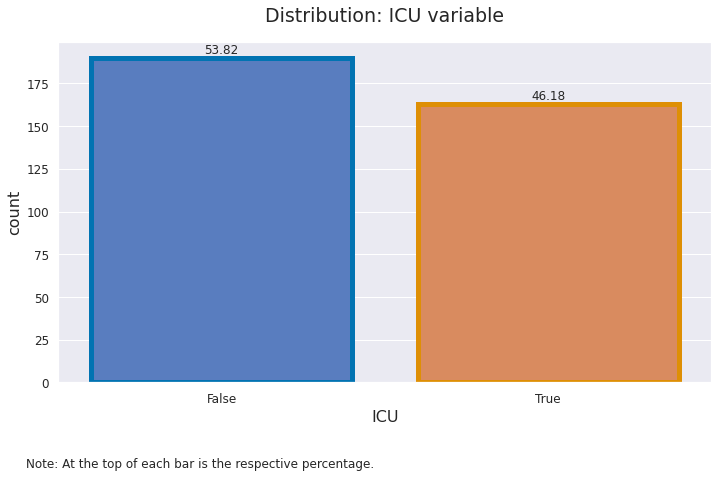

In [181]:
#plt.figure(figsize=(9,6))

ax = sns.countplot(x=patients_cleaned.query('WINDOW == "0-2"')['ICU'],
                   palette="muted",
                   linewidth=5,
                   edgecolor=sns.color_palette("colorblind"))

window_0_2_ICU = patients_cleaned.query('WINDOW == "0-2"')[['ICU']]
window_0_2_ICU_freq_table = create_freq_table(window_0_2_ICU, 'ICU')

add_labels_to_bars(ax, window_0_2_ICU_freq_table['percentage'], 2.6)

plt.title('Distribution: ICU variable', pad=20)
plt.xticks([0, 1],['False', 'True'])

ax.text(-0.6, -50, 'Note: At the top of each bar is the respective percentage.');

### Although we don't have a fifty-fifty distribution of the target, it has a good balance.

### Continuing the analysis... What about missing values?

In [197]:
patients_cleaned.isna().sum().values

array([   0,    0,    0,    0,    5,    5,    5,    5,    5,    5,    5,
          5,    5, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026,
       1026, 1026, 1026, 1026, 1026, 1026, 1026, 10

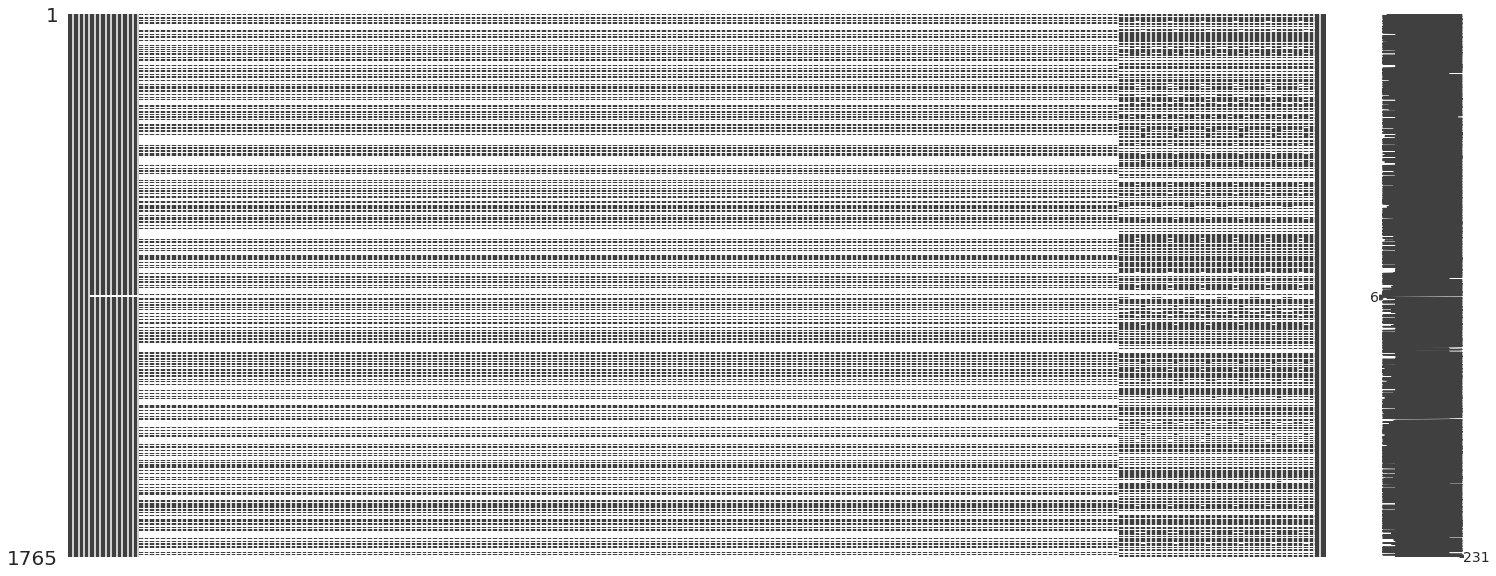

In [202]:
msno.matrix(patients_cleaned);